**Gerekli Kütüphanelerin Eklenmesi**

In [ ]:
import glob
import os
import numpy as np
from matplotlib import pyplot as plt
import scipy.io.wavfile as wav
from numpy.lib import stride_tricks
from PIL import Image
import pandas as pd
import cv2
import shutil
import librosa
from tqdm import tqdm
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.keras.models import Sequential,Model
from tensorflow.python.keras.layers import Dense,Dropout,Activation,Flatten,Lambda
from tensorflow.python.keras.callbacks import ModelCheckpoint
from datetime import datetime
import torchvision.transforms as transforms
from os import listdir
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

**Google Drive için gerekli bağlantıyı kurmak**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Gerekli olan değişkenler**

In [ ]:
image_list = []
number_of_elements_on_each_file = np.empty(10, dtype='int')
total_number = 0
temp = 0

**Spectogramların bır listeye kaydedilmesi**

In [ ]:
for i in range(0, 10):
  for images in os.listdir(path = f'/content/drive/MyDrive/UrbanSound8K/spectrograms/{i}'): 
    # check if the image ends with png
    if (images.endswith(".png")):
        image_list.append(images)
    
  total_number = len(image_list) - temp
  print(total_number, len(image_list) ,temp) 
  number_of_elements_on_each_file[i] = total_number
  temp =  len(image_list)  

1000 1000 0
429 1429 1000
1000 2429 1429
1000 3429 2429
1000 4429 3429
1000 5429 4429
374 5803 5429
1000 6803 5803
929 7732 6803
1000 8732 7732


**Grayscale - Resıze - Normalize dan oluşan resimlerin kaydedilmesi için gereken alt dosyaların bulunması**

In [ ]:
def decide_func(num):
  if i < 1000:
    return 0
  elif i >= 1000 and i < 1429:
    return 1
  elif i >= 1429 and i < 2429:
    return 2   
  elif i >= 2429 and i < 3429:
    return 3
  elif i >= 3429 and i < 4429:
    return 4
  elif i >= 4429 and i < 5429:
    return 5
  elif i >= 5429 and i < 5803:
    return 6
  elif i >= 5803 and i < 6803:
    return 7
  elif i >= 6803 and i < 7732:
    return 8
  elif i >= 7732 and i < 8732:
    return 9


In [ ]:
def decide_func_for_final(num):
  if i < 1000:
    return 'air_conditioner'
  elif i >= 1000 and i < 1429:
    return 'car_horn'
  elif i >= 1429 and i < 2429:
    return 'children_playing'   
  elif i >= 2429 and i < 3429:
    return 'dog_bark'
  elif i >= 3429 and i < 4429:
    return 'drilling'
  elif i >= 4429 and i < 5429:
    return 'engine_idling'
  elif i >= 5429 and i < 5803:
    return 'gun_shot'
  elif i >= 5803 and i < 6803:
    return 'jackhammer'
  elif i >= 6803 and i < 7732:
    return 'siren'
  elif i >= 7732 and i < 8732:
    return 'street_music'


**Toplam Spectogram Sayısı**

In [ ]:
size_of_image_list = len(image_list)
print(size_of_image_list)

8732


**Her bir alt klosördeki spectogram sayısı**

In [ ]:
for i in number_of_elements_on_each_file:
  print(i)

1000
429
1000
1000
1000
1000
374
1000
929
1000


**Spectogramların Grascale Dönüşümü**

In [ ]:
for i in range(0,size_of_image_list):
  j = decide_func(i)
  path = f"/content/drive/MyDrive/UrbanSound8K/spectrograms/{j}"
  text_file = glob.glob(path + f"/**/*{image_list[i]}", recursive = True)

  image = cv2.imread(text_file[0])
  gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  print(f"{image_list[i]} image is writing to the grayscale file to {j} subset, # of the image is {i}")
  cv2.imwrite(f"/content/drive/MyDrive/UrbanSound8K/grayscale/{j}/{image_list[i]}", gray_image)

Görüntülenen çıkış son 5000 satıra kısaltıldı.
167702-4-7-1.png image is writing to the grayscale file to 4 subset, # of the image is 3732
167702-4-7-0.png image is writing to the grayscale file to 4 subset, # of the image is 3733
167702-4-5-0.png image is writing to the grayscale file to 4 subset, # of the image is 3734
167702-4-8-0.png image is writing to the grayscale file to 4 subset, # of the image is 3735
167750-4-0-0.png image is writing to the grayscale file to 4 subset, # of the image is 3736
167702-4-9-0.png image is writing to the grayscale file to 4 subset, # of the image is 3737
167750-4-2-0.png image is writing to the grayscale file to 4 subset, # of the image is 3738
168037-4-1-0.png image is writing to the grayscale file to 4 subset, # of the image is 3739
168037-4-0-0.png image is writing to the grayscale file to 4 subset, # of the image is 3740
167750-4-1-0.png image is writing to the grayscale file to 4 subset, # of the image is 3741
167750-4-3-0.png image is writing

**Grascale yapılmış Spectogramların resize edilmesi**

In [ ]:
for i in range(0,size_of_image_list):
  j = decide_func(i)
  image = Image.open(f"/content/drive/MyDrive/UrbanSound8K/grayscale/{j}/{image_list[i]}")
  
  width, height = image.size
  print(image.size)
  left = 10
  top = height / 500
  right = 500
  bottom = 6.6 * height / 8
  im1 = image.crop((left, top, right, bottom))
  newsize = (300, 300)
  im1 = im1.resize(newsize)

  print(f"{image_list[i]} image is writing to the grayscale file to {j} subset, # of the image is {i}")

  im1.save(f"/content/drive/MyDrive/UrbanSound8K/resizing/{j}/{image_list[i]}")

Görüntülenen çıkış son 5000 satıra kısaltıldı.
(500, 374)
177537-7-0-16.png image is writing to the grayscale file to 7 subset, # of the image is 6232
(500, 374)
177537-7-0-18.png image is writing to the grayscale file to 7 subset, # of the image is 6233
(500, 374)
177537-7-0-19.png image is writing to the grayscale file to 7 subset, # of the image is 6234
(500, 374)
177537-7-0-20.png image is writing to the grayscale file to 7 subset, # of the image is 6235
(500, 374)
177537-7-0-2.png image is writing to the grayscale file to 7 subset, # of the image is 6236
(500, 374)
177537-7-0-21.png image is writing to the grayscale file to 7 subset, # of the image is 6237
(500, 374)
177537-7-0-22.png image is writing to the grayscale file to 7 subset, # of the image is 6238
(500, 374)
177537-7-0-23.png image is writing to the grayscale file to 7 subset, # of the image is 6239
(500, 374)
177537-7-0-24.png image is writing to the grayscale file to 7 subset, # of the image is 6240
(500, 374)
177537-

**Resıze ve grascle yapılmış spectogramların normalızasyonun yapılması**

In [ ]:
for i in range(0,size_of_image_list):
  j = decide_func(i)
  image = cv2.imread(f"/content/drive/MyDrive/UrbanSound8K/resizing/{j}/{image_list[i]}")
  image_norm = cv2.normalize(image, None, alpha=0,beta=200, norm_type=cv2.NORM_MINMAX)
  cv2.imwrite(f"/content/drive/MyDrive/UrbanSound8K/normalizasyon/{j}/{image_list[i]}", image_norm)
  print(f"{image_list[i]} image is writing to the grayscale file to {j} subset, # of the image is {i}")

Görüntülenen çıkış son 5000 satıra kısaltıldı.
167702-4-7-1.png image is writing to the grayscale file to 4 subset, # of the image is 3732
167702-4-7-0.png image is writing to the grayscale file to 4 subset, # of the image is 3733
167702-4-5-0.png image is writing to the grayscale file to 4 subset, # of the image is 3734
167702-4-8-0.png image is writing to the grayscale file to 4 subset, # of the image is 3735
167750-4-0-0.png image is writing to the grayscale file to 4 subset, # of the image is 3736
167702-4-9-0.png image is writing to the grayscale file to 4 subset, # of the image is 3737
167750-4-2-0.png image is writing to the grayscale file to 4 subset, # of the image is 3738
168037-4-1-0.png image is writing to the grayscale file to 4 subset, # of the image is 3739
168037-4-0-0.png image is writing to the grayscale file to 4 subset, # of the image is 3740
167750-4-1-0.png image is writing to the grayscale file to 4 subset, # of the image is 3741
167750-4-3-0.png image is writing

**Normalization Dosyasinin icindeki tum verilerin goruntu etiket formatinda baska bir dosyaya kaydedilmesi**

In [ ]:
for i in range(0,size_of_image_list):
  j = decide_func(i)
  l = decide_func_for_final(i)
  image = cv2.imread(f"/content/drive/MyDrive/UrbanSound8K/normalizasyon/{j}/{image_list[i]}")
  cv2.imwrite(f"/content/drive/MyDrive/UrbanSound8K/final_spectograms/{l}/{image_list[i]}", image)
  print(f"{image_list[i]} image is writing to the grayscale file to {j} subset, # of the image is {i}")

Görüntülenen çıkış son 5000 satıra kısaltıldı.
167702-4-7-1.png image is writing to the grayscale file to 4 subset, # of the image is 3732
167702-4-7-0.png image is writing to the grayscale file to 4 subset, # of the image is 3733
167702-4-5-0.png image is writing to the grayscale file to 4 subset, # of the image is 3734
167702-4-8-0.png image is writing to the grayscale file to 4 subset, # of the image is 3735
167750-4-0-0.png image is writing to the grayscale file to 4 subset, # of the image is 3736
167702-4-9-0.png image is writing to the grayscale file to 4 subset, # of the image is 3737
167750-4-2-0.png image is writing to the grayscale file to 4 subset, # of the image is 3738
168037-4-1-0.png image is writing to the grayscale file to 4 subset, # of the image is 3739
168037-4-0-0.png image is writing to the grayscale file to 4 subset, # of the image is 3740
167750-4-1-0.png image is writing to the grayscale file to 4 subset, # of the image is 3741
167750-4-3-0.png image is writing

**Her aşamaya ait spectogramlardan bir örnek**

Result of the spectogram


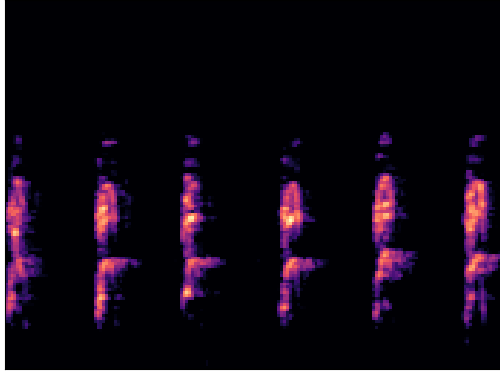

Result of the grayscale


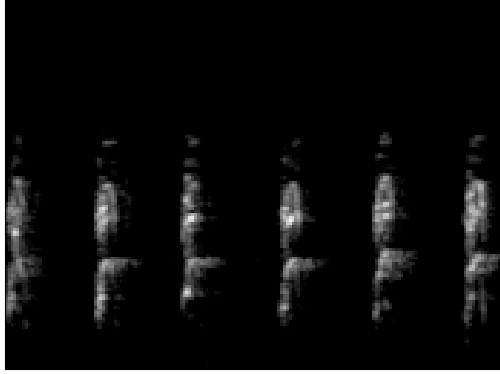

Result of the resizing


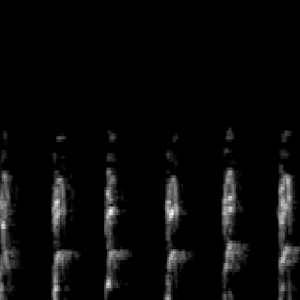

Result of the normalization


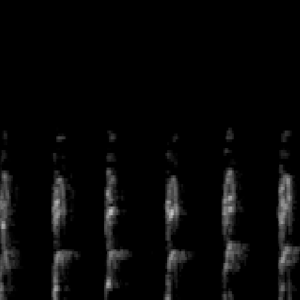

In [ ]:
print('Result of the spectogram')
img = cv2.imread("/content/drive/MyDrive/UrbanSound8K/spectrograms/3/100795-3-1-1.png")
cv2_imshow(img)

print('Result of the grayscale')
img = cv2.imread("/content/drive/MyDrive/UrbanSound8K/grayscale/3/100795-3-1-1.png")
cv2_imshow(img)

print('Result of the resizing')
img = cv2.imread("/content/drive/MyDrive/UrbanSound8K/resizing/3/100795-3-1-1.png")
cv2_imshow(img)

print('Result of the normalization')
img = cv2.imread("/content/drive/MyDrive/UrbanSound8K/normalizasyon/3/100795-3-1-1.png")
cv2_imshow(img)